In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 计算成对的欧式距离的函数
def pairwise_distances(X):
    return np.sqrt(np.sum((X[:, None] - X) ** 2, axis=2))

# 计算最近邻的索引
def nearest_neighbors(X, k):
    dist_matrix = pairwise_distances(X)
    return np.argsort(dist_matrix, axis=1)[:, 1:k+1]

def compute_local_scale_parameter(X, k):
    dist_matrix = pairwise_distances(X)
    knn_distances = np.sort(dist_matrix, axis=1)[:, 1:k+1]  # 每个数据点的 k 近邻距离
    local_scale = np.mean(knn_distances, axis=1)  # 可以使用均值、中位数等作为局部尺度参数
    return local_scale

# 根据数据分布特性来计算 t，例如使用数据的方差、标准差等
def compute_data_based_scale_parameter(X):
    data_variance = np.var(X, axis=0)  # 按列计算数据的方差
    data_scale = np.mean(data_variance)  # 使用方差均值作为数据尺度参数
    return data_scale

def construct_adjacency_matrix(X, method, epsilon, k):
    n = len(X)  # 计算数据集样本点的数量
    adjacency_matrix = np.zeros((n, n))  # 创建一个全零的邻接矩阵，尺寸为 (n, n)
    t=100
    if method == 'E':  # 如果方法为epsilon邻域
        for i in range(n):  # 对于数据集中的每个样本点 i
            for j in range(n):  # 对于数据集中的每个样本点 j
                if np.linalg.norm(X[i] - X[j]) < epsilon:  # 如果样本点 i 和 j 之间的距离小于 epsilon
                    adjacency_matrix[i, j] = np.exp(- np.linalg.norm(X[i] - X[j]) ** 2 / t)  # 使用热核方法计算权重
                    adjacency_matrix[j, i] = np.exp(- np.linalg.norm(X[j] - X[i]) ** 2 / t)  #邻接矩阵为对称矩阵

    elif method == 'knn':  # 如果方法为k最近邻
        dist_matrix = pairwise_distances(X)  # 计算数据集中样本点之间的距离
        knn_matrix = nearest_neighbors(X, k)  # 计算每个样本点的 k 个最近邻索引
        for i in range(len(X)):  # 对于数据集中的每个样本点 i
            for j in knn_matrix[i]:  # 对于样本点 i 的 k 个最近邻点 j
                adjacency_matrix[i][int(j)] = np.exp(- dist_matrix[i][int(j)] ** 2 / t)  # 使用热核方法计算权重
                adjacency_matrix[int(j)][i] = np.exp(- dist_matrix[int(j)][i] ** 2 / t)  #邻接矩阵为对称矩阵

    return adjacency_matrix  # 返回构建完成的邻接矩阵

# 计算度矩阵和拉普拉斯矩阵
def compute_laplacian(adjacency_matrix):
    degree_matrix = np.diag(np.sum(adjacency_matrix, axis=1))
    laplacian_matrix = degree_matrix - adjacency_matrix
    return laplacian_matrix

# 计算 LPP 的嵌入结果
def LPP(X, n_components, method, epsilon, k):
    adjacency_matrix = construct_adjacency_matrix(X, method, epsilon, k)
    laplacian_matrix = compute_laplacian(adjacency_matrix)
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)
    indices = np.argsort(eigenvalues)
    embeddings = eigenvectors[:, indices[1:n_components+1]]


    
    return embeddings

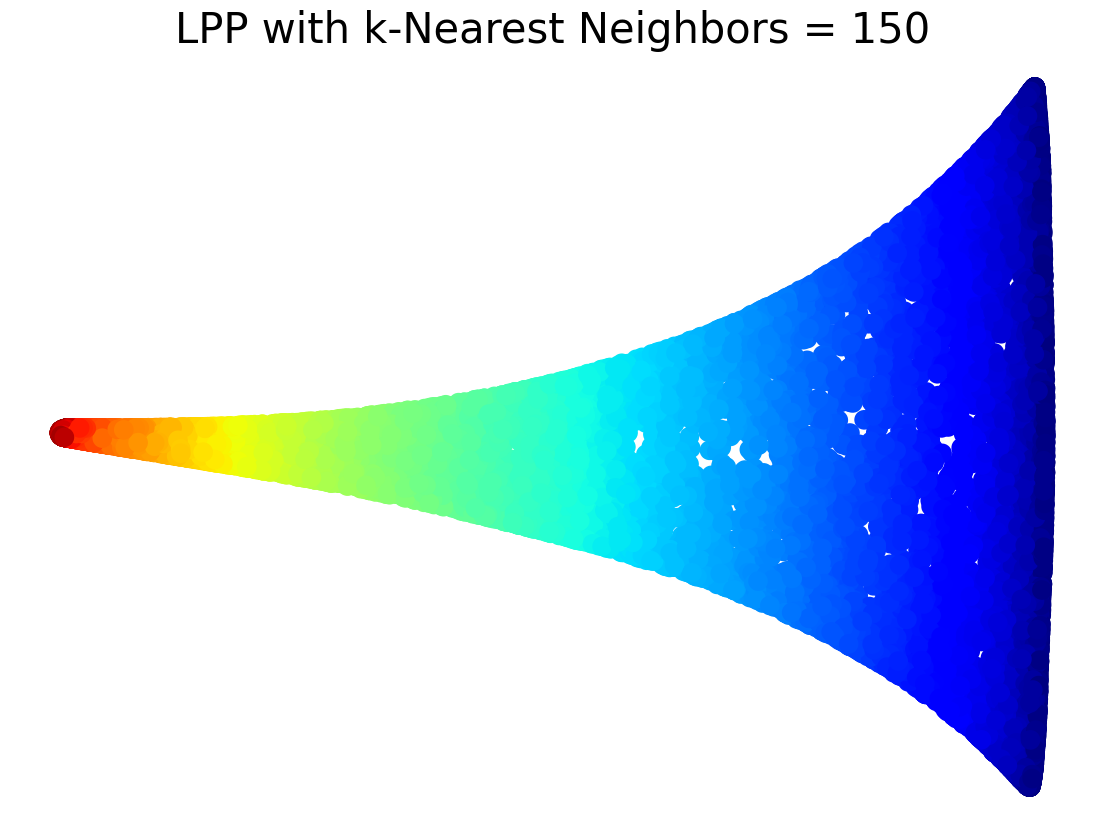

In [2]:
# 加载数据集
X = np.load('D:/OneDrive - email.szu.edu.cn/Manifold Learning/swiss roll-10000.npy')

# 将 X 转换为 (n_samples, n_features)
X_trans = np.transpose(X)

# 设置参数
n_components = 2
method = 'knn'  # epsilon 或 knn，根据需要选择构建邻接图的方式
epsilon = 10  # 或 k 数量，取决于所选的方法
k = 150

# 执行 LPP 算法降维
lpp_embeddings = LPP(X_trans, n_components, method, epsilon, k)

# 绘制 LPP 的二维嵌入结果
# 绘制投影图
plt.figure(figsize=(14,10))
plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((X_trans[:,0]**2+X_trans[:,2]**2)/100), s=200, lw=0, alpha=1)
plt.title('LPP with k-Nearest Neighbors = ' + str(k), size=30)
plt.axis("off")
plt.show()